<h1 align="center">Linear vs. Kernel Models in Simulated Returns</h1>

<p align="center">
  <strong>Author:</strong> SALIOLA BUCELLI Andrea<br>
</p>
<p align="center">
  <strong>Date:</strong> December 1, 2025<br>
</p>
<p align="center">
  <a align="center", href="https://github.com/ansabu01/Linear_vs_Kernel_Models_in_Simulated_Returns">
    Project Repository
  </a>
</p>

---

### Import Libraries

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Graphs Settings

In [50]:
plt.rcParams.update({
    "font.size": 15,                                # base font size
    "axes.titlesize": 18,                           # title of each subplot
    "axes.labelsize": 15,                           # axis labels
    "xtick.labelsize": 15,                          # x ticks
    "ytick.labelsize": 15,                          # y ticks
    "legend.fontsize": 15,                          # legend text
    "legend.loc": "upper left",                     # legend position
})

### Simulation Settings

$$
\begin{aligned}
\text{Market factor:}       &\quad F_t \sim \mathcal{N}(0,1) \\
\text{Volatility driver:}   &\quad Z_t \sim \mathcal{N}(0,1) \\
\text{Volatility indicator:}&\quad V_t = |Z_t| \\
\text{Regime indicator:}    &\quad H_t = \mathbb{1}_{(V_t > 1)} \\
\text{Noise term:}          &\quad \varepsilon_t \sim \mathcal{N}(0,\sigma^2) \\
\text{Noise scale:}         &\quad \sigma = 0.03 \\
\text{Parameter vector:}    &\quad \theta = (\theta_0, \theta_1, \theta_2, \theta_3)
\end{aligned}
$$

In [51]:
n = 500                                             # Number of observations

rng = np.random.default_rng(42)                     # Random number generator

F = rng.normal(loc=0.0, scale=1.0, size=n)          # Market factor F ~ N(0,1)

Z = rng.normal(loc=0.0, scale=1.0, size=n)          # Volatility indicator V = |Z| with Z ~ N(0,1)
V = np.abs(Z)                                       # Volatility

H = (V > 1).astype(int)                             # Regime indicator H = 1 if high volatility, else 0

sigma = 0.03                                        # Standard deviation of the noise
eps = rng.normal(loc=0.0, scale=sigma, size=n)      # Noise ε ~ N(0, σ²)

theta = np.array([                                  # Parameter vector:
     0.002,                                         # Intercept
     0.040,                                         # Linear F
    -0.030,                                         # Linear V
     0.060,                                         # Quadratic F^2
     0.050,                                         # Interaction F*V
     0.080                                          # Switching term
])

## 1. Quadratic Nonlinearity

$$
R_t = \theta_0 + \theta_1 F_t + \theta_2 V_t + \theta_3 F_t^2 + \varepsilon_t
$$

$$
\begin{aligned}
\text{a) Quadratic:} &\quad \ F_t^2
\end{aligned}
$$

          F         V  R_quadratic
0  0.304717  1.363862    -0.022935
1 -1.039984  0.895185    -0.023440
2  0.750451  0.719480     0.031790
3  0.940565  1.502503     0.066645
4 -1.951035  2.964529     0.063505


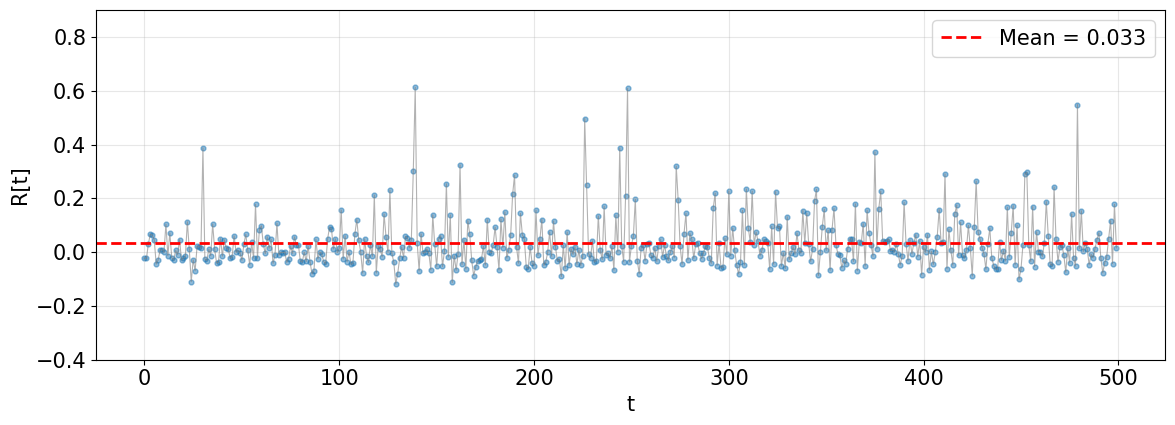

In [52]:
R_quadratic = (
      theta[0]
    + theta[1] * F
    + theta[2] * V
    + theta[3] * (F ** 2)
    + eps
)

data_quadratic = pd.DataFrame({                     # Final dataset            
    "F": F,                                         # Market factor
    "V": V,                                         # Volatility indicator
    "R_quadratic": R_quadratic                      # Target return
})

print(data_quadratic.head())

R_mean_quadratic = R_quadratic.mean()               # Mean of returns

plt.figure(figsize=(12, 4.5))
plt.plot(R_quadratic, linewidth=0.8, color="gray", alpha=0.6)
plt.scatter(range(n), R_quadratic, marker='o', s=12, alpha=0.5)
plt.axhline(R_mean_quadratic, color="red", linestyle="--", linewidth=2, label=f"Mean = {R_mean_quadratic:.3f}")

plt.xlabel("t")
plt.ylabel("R[t]")
plt.ylim(-0.4, 0.9)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("images/returns_quadratic.pdf", dpi=300)
plt.show()

### 1.1. Linear Regression

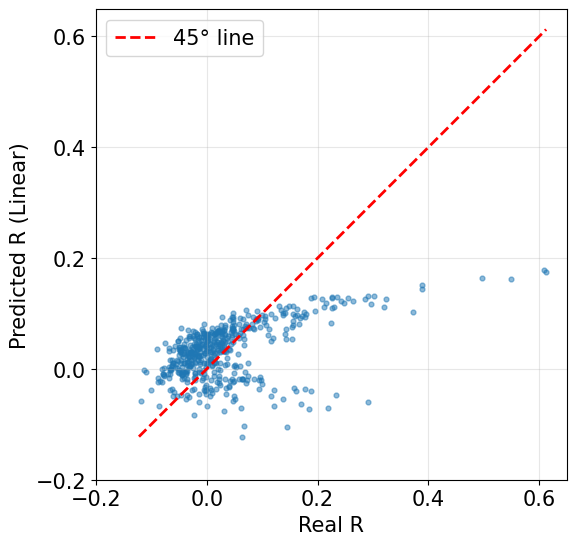

In [53]:
X = data_quadratic[["F", "V"]].to_numpy()               # Predictors
y_quadratic = data_quadratic["R_quadratic"].to_numpy()  # Target variable
model = LinearRegression()
model.fit(X, y_quadratic)
R_pred_linear_quadratic = model.predict(X)          # In-sample predictions (linear)

plt.figure(figsize=(6, 6))
plt.scatter(y_quadratic, R_pred_linear_quadratic, marker='o', s=12, alpha=0.5)

min_val = min(y_quadratic.min(), R_pred_linear_quadratic.min())
max_val = max(y_quadratic.max(), R_pred_linear_quadratic.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="45° line")

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Real R")
plt.ylabel("Predicted R (Linear)")
plt.xticks(np.arange(-0.2, 0.7, 0.2))
plt.yticks(np.arange(-0.2, 0.7, 0.2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("images/linear_quadratic.pdf", dpi=300)
plt.show()

### 1.2. RBF Gram Matrix

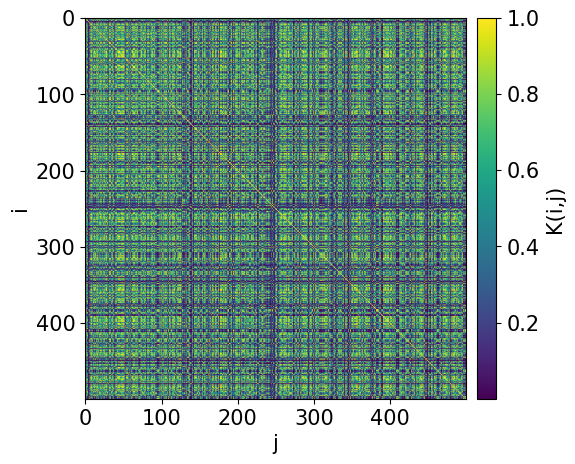

In [54]:
gamma = 0.5                                         # Inverse length-scale (kernel width) parameter
lam = 1e-2                                          # Regularization parameter (ridge penalty)

sq_norms = np.sum(X**2, axis=1).reshape(-1, 1)      # Squared norms of rows of X    (n x 1)
dists_sq = sq_norms + sq_norms.T - 2 * X @ X.T      # Pairwise squared distances    (n x n)
K = np.exp(-gamma * dists_sq)                       # Gram Matrix with RBF kernel   (n x n)

fig, ax = plt.subplots(figsize=(6, 6))

im = ax.imshow(K, cmap="viridis", aspect='equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="3%")

cbar = plt.colorbar(im, cax=cax)
cbar.set_label("K(i,j)", rotation=90)

ax.set_xlabel("j")
ax.set_ylabel("i")

plt.tight_layout()
plt.savefig("images/gram_matrix.pdf", dpi=300)
plt.show()

### 1.3. Kernel Ridge Regression

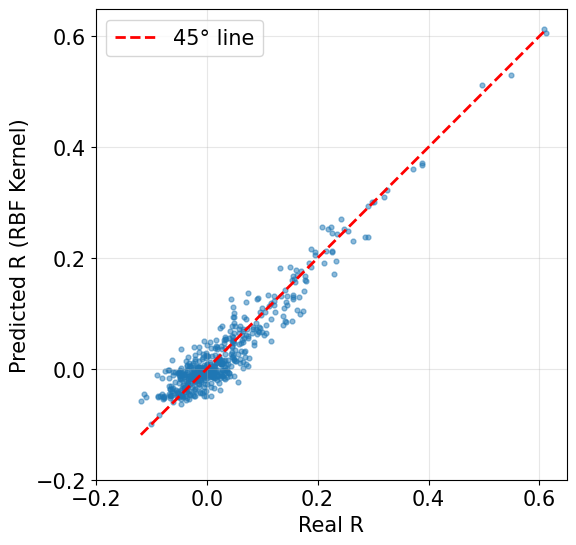

In [55]:
A = K + lam * np.eye(len(X))                        # Regularized Gram Matrix
alpha = np.linalg.solve(A, y_quadratic)             # Solve for dual coefficients α
R_pred_kernel_quadratic = K @ alpha                 # In-sample predictions (kernel)

plt.figure(figsize=(6, 6))
plt.scatter(y_quadratic, R_pred_kernel_quadratic, marker='o', s=12, alpha=0.5)

min_val = min(y_quadratic.min(), R_pred_kernel_quadratic.min())
max_val = max(y_quadratic.max(), R_pred_kernel_quadratic.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="45° line")

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Real R")
plt.ylabel("Predicted R (RBF Kernel)")
plt.xticks(np.arange(-0.2, 0.7, 0.2))
plt.yticks(np.arange(-0.2, 0.7, 0.2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("images/kernel_quadratic.pdf", dpi=300)
plt.show()

### 1.4. Performance Metrics

In [56]:
# Compute metrics for Linear Regression
r2_lin = r2_score(y_quadratic, R_pred_linear_quadratic)
rmse_lin = np.sqrt(mean_squared_error(y_quadratic, R_pred_linear_quadratic))
mae_lin = mean_absolute_error(y_quadratic, R_pred_linear_quadratic)
bias_lin = np.mean(R_pred_linear_quadratic - y_quadratic)
corr_lin = np.corrcoef(y_quadratic, R_pred_linear_quadratic)[0,1]

# Compute metrics for Kernel Ridge Regression
r2_ker = r2_score(y_quadratic, R_pred_kernel_quadratic)
rmse_ker = np.sqrt(mean_squared_error(y_quadratic, R_pred_kernel_quadratic))
mae_ker = mean_absolute_error(y_quadratic, R_pred_kernel_quadratic)
bias_ker = np.mean(R_pred_kernel_quadratic - y_quadratic)
corr_ker = np.corrcoef(y_quadratic, R_pred_kernel_quadratic)[0,1]

# Build summary table
summary_quadratic = pd.DataFrame({
    "Model": ["Linear", "Kernel"],
    "R2": [r2_lin, r2_ker],
    "RMSE": [rmse_lin, rmse_ker],
    "MAE": [mae_lin, mae_ker],
    "Bias": [bias_lin, bias_ker],
    "Corr(y, y_hat)": [corr_lin, corr_ker]
}).round(6)

print("Case 1 performance metrics:")
display(summary_quadratic)

Case 1 performance metrics:


,Model,R2,RMSE,MAE,Bias,"Corr(y, y_hat)"
0,Linear,0.261338,0.082031,0.059006,-0.000000,0.511212
1,Kernel,0.906657,0.029161,0.023096,-0.000018,0.952189


## 2. Quadratic Nonlinearity and Interaction

$$
R_t = \theta_0 + \theta_1 F_t + \theta_2 V_t + \theta_3 F_t^2 + \theta_4 F_t V_t + \varepsilon_t
$$

$$
\begin{aligned}
\text{a) Quadratic:}   &\quad \ F_t^2 \\
\text{b) Interaction:} &\quad \ F_t V_t
\end{aligned}
$$

          F         V  R_interaction
0  0.304717  1.363862      -0.002155
1 -1.039984  0.895185      -0.069988
2  0.750451  0.719480       0.058787
3  0.940565  1.502503       0.137305
4 -1.951035  2.964529      -0.225690


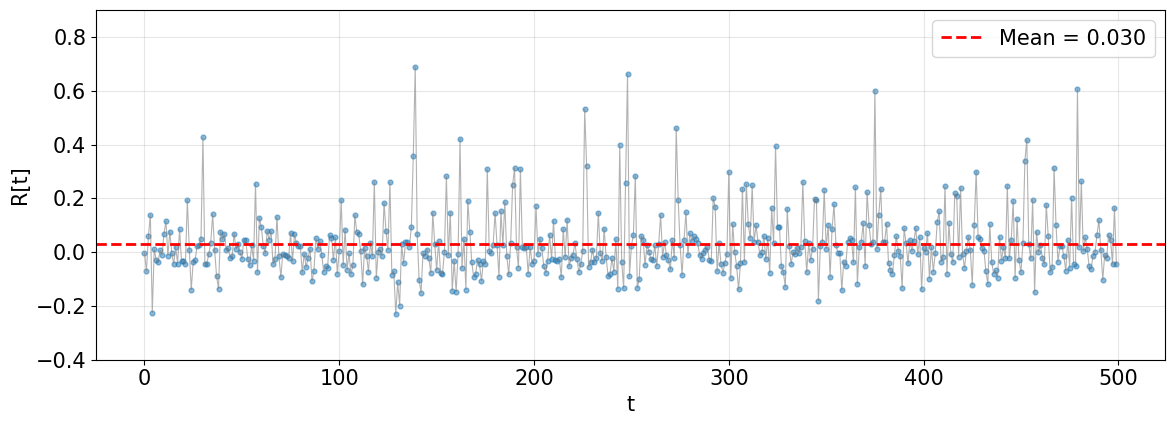

In [57]:
R_interaction = (
      theta[0]
      + theta[1] * F
      + theta[2] * V
      + theta[3] * (F ** 2)
      + theta[4] * (F * V)
      + eps
)

data_interaction = pd.DataFrame({                   # Final dataset
    "F": F,                                         # Market factor
    "V": V,                                         # Volatility indicator
    "R_interaction": R_interaction                  # Target return
})

print(data_interaction.head())

R_mean_interaction = R_interaction.mean()           # Mean of returns

plt.figure(figsize=(12, 4.5))
plt.plot(R_interaction, linewidth=0.8, color="gray", alpha=0.6)
plt.scatter(range(n), R_interaction, marker='o', s=12, alpha=0.5)
plt.axhline(R_mean_interaction, color="red", linestyle="--", linewidth=2, label=f"Mean = {R_mean_interaction:.3f}")

plt.xlabel("t")
plt.ylabel("R[t]")
plt.ylim(-0.4, 0.9)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("images/returns_interaction.pdf", dpi=300)
plt.show()

### 2.1. Linear Regression

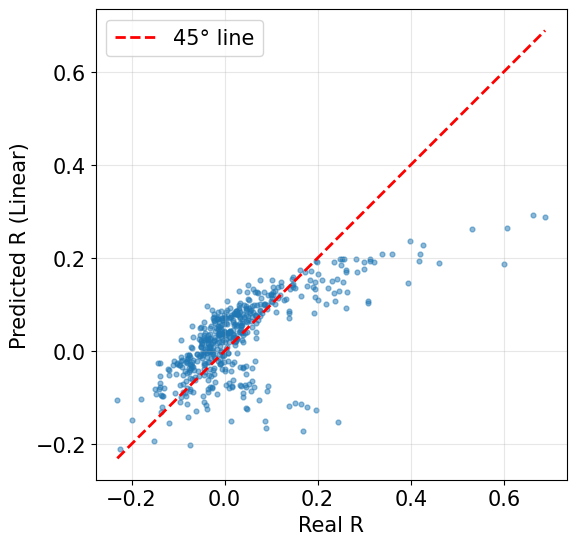

In [58]:
X = data_interaction[["F", "V"]].to_numpy()                     # Predictors
y_interaction = data_interaction["R_interaction"].to_numpy()    # Target variable
model = LinearRegression()
model.fit(X, y_interaction)
R_pred_linear_interaction = model.predict(X)        # In-sample predictions (linear)

plt.figure(figsize=(6, 6))
plt.scatter(y_interaction, R_pred_linear_interaction, marker='o', s=12, alpha=0.5)

min_val = min(y_interaction.min(), R_pred_linear_interaction.min())
max_val = max(y_interaction.max(), R_pred_linear_interaction.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="45° line")

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Real R")
plt.ylabel("Predicted R (Linear)")
plt.xticks(np.arange(-0.2, 0.7, 0.2))
plt.yticks(np.arange(-0.2, 0.7, 0.2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("images/linear_interaction.pdf", dpi=300)
plt.show()

### 2.2. Kernel Ridge Regression

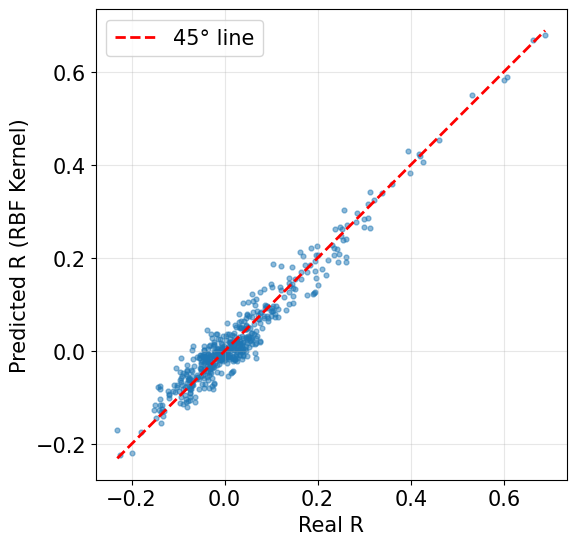

In [59]:
A = K + lam * np.eye(len(X))                        # Regularized Gram Matrix
alpha = np.linalg.solve(A, y_interaction)           # Solve for dual coefficients α
R_pred_kernel_interaction = K @ alpha               # In-sample predictions (kernel)

plt.figure(figsize=(6, 6))
plt.scatter(y_interaction, R_pred_kernel_interaction, marker='o', s=12, alpha=0.5)

min_val = min(y_interaction.min(), R_pred_kernel_interaction.min())
max_val = max(y_interaction.max(), R_pred_kernel_interaction.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="45° line")

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Real R")
plt.ylabel("Predicted R (RBF Kernel)")
plt.xticks(np.arange(-0.2, 0.7, 0.2))
plt.yticks(np.arange(-0.2, 0.7, 0.2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("images/kernel_interaction.pdf", dpi=300)
plt.show()

### 2.3. Performance Metrics

In [60]:
# Compute metrics for Linear Regression
r2_lin = r2_score(y_interaction, R_pred_linear_interaction)
rmse_lin = np.sqrt(mean_squared_error(y_interaction, R_pred_linear_interaction))
mae_lin = mean_absolute_error(y_interaction, R_pred_linear_interaction)
bias_lin = np.mean(R_pred_linear_interaction - y_interaction)
corr_lin = np.corrcoef(y_interaction, R_pred_linear_interaction)[0, 1]

# Compute metrics for Kernel Ridge Regression
r2_ker = r2_score(y_interaction, R_pred_kernel_interaction)
rmse_ker = np.sqrt(mean_squared_error(y_interaction, R_pred_kernel_interaction))
mae_ker = mean_absolute_error(y_interaction, R_pred_kernel_interaction)
bias_ker = np.mean(R_pred_kernel_interaction - y_interaction)
corr_ker = np.corrcoef(y_interaction, R_pred_kernel_interaction)[0, 1]

# Build summary table
summary_interaction = pd.DataFrame({
    "Model": ["Linear", "Kernel"],
    "R2": [r2_lin, r2_ker],
    "RMSE": [rmse_lin, rmse_ker],
    "MAE": [mae_lin, mae_ker],
    "Bias": [bias_lin, bias_ker],
    "Corr(y, y_hat)": [corr_lin, corr_ker]
}).round(6)

print("Case 2 performance metrics:")
display(summary_interaction)

Case 2 performance metrics:


,Model,R2,RMSE,MAE,Bias,"Corr(y, y_hat)"
0,Linear,0.500116,0.085491,0.060026,-0.000000,0.707189
1,Kernel,0.941819,0.029166,0.023116,-0.000017,0.970475


## 3. Quadratic Nonlinearity, Interaction, and Regime Switching

$$
R_t = \theta_0 + \theta_1 F_t + \theta_2 V_t + \theta_3 F_t^2 + \theta_4 F_t V_t + \theta_5 H_t F_t + \varepsilon_t
$$

$$
\begin{aligned}
\text{a) Quadratic:}    &\quad \ F_t^2 \\
\text{b) Interaction:}  &\quad \ F_t V_t \\
\text{c) Switching:}    &\quad \ H_t F_t
\end{aligned}
$$

          F         V  H  R_switching
0  0.304717  1.363862  1     0.022222
1 -1.039984  0.895185  0    -0.069988
2  0.750451  0.719480  0     0.058787
3  0.940565  1.502503  1     0.212550
4 -1.951035  2.964529  1    -0.381773


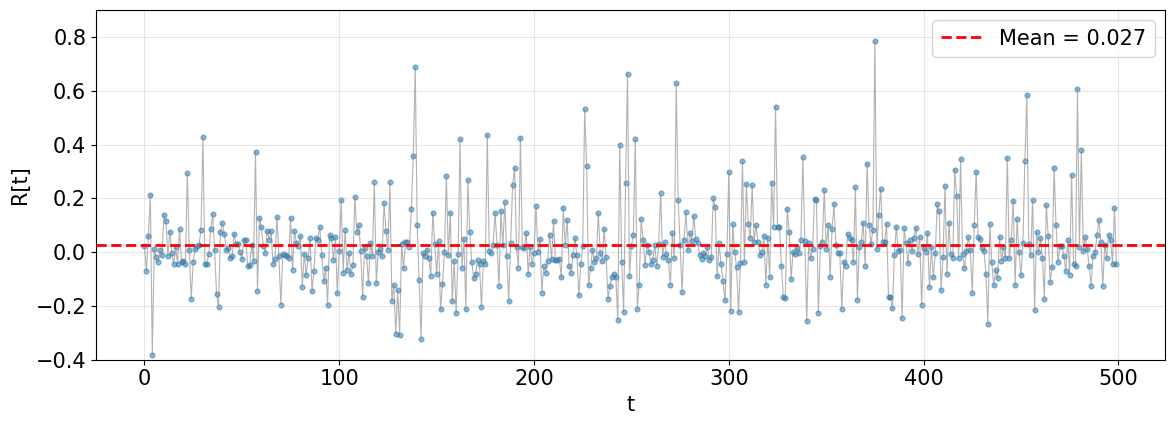

In [61]:
R_switching = (
      theta[0]
      + theta[1] * F
      + theta[2] * V
      + theta[3] * (F ** 2)
      + theta[4] * (F * V)
      + theta[5] * (H * F)
      + eps
)

data_switching = pd.DataFrame({                     # Final dataset
    "F": F,                                         # Market factor
    "V": V,                                         # Volatility indicator
    "H": H,                                         # Regime indicator
    "R_switching": R_switching                      # Target return
})                  

print(data_switching.head())

R_mean_switching = R_switching.mean()               # Mean of returns

plt.figure(figsize=(12, 4.5))
plt.plot(R_switching, linewidth=0.8, color="gray", alpha=0.6)
plt.scatter(range(n), R_switching, marker='o', s=12, alpha=0.5)
plt.axhline(R_mean_switching, color="red", linestyle="--", linewidth=2, label=f"Mean = {R_mean_switching:.3f}")

plt.xlabel("t")
plt.ylabel("R[t]")
plt.ylim(-0.4, 0.9)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("images/returns_switching.pdf", dpi=300)
plt.show()

### 3.1. Linear Regression

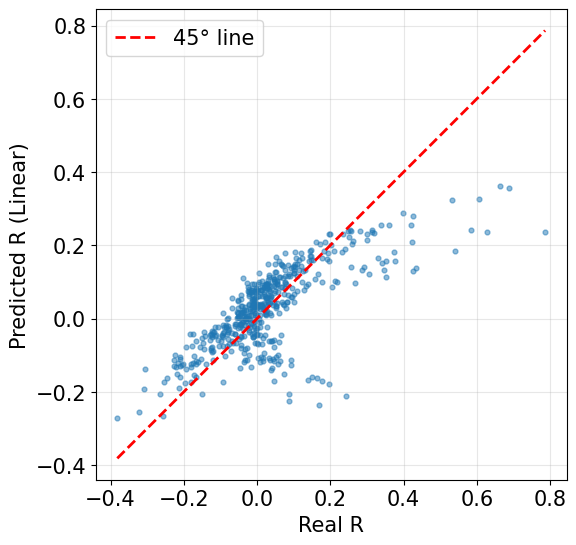

In [62]:
X = data_switching[["F", "V"]].to_numpy()               # Predictors
y_switching = data_switching["R_switching"].to_numpy()  # Target variable
model = LinearRegression()
model.fit(X, y_switching)
R_pred_linear_switching = model.predict(X)          # In-sample predictions (linear)

plt.figure(figsize=(6, 6))
plt.scatter(y_switching, R_pred_linear_switching, marker='o', s=12, alpha=0.5)

min_val = min(y_switching.min(), R_pred_linear_switching.min())
max_val = max(y_switching.max(), R_pred_linear_switching.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="45° line")

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Real R")
plt.ylabel("Predicted R (Linear)")
plt.xticks(np.arange(-0.4, 0.9, 0.2))
plt.yticks(np.arange(-0.4, 0.9, 0.2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("images/linear_switching.pdf", dpi=300)
plt.show()

### 3.2. Kernel Ridge Regression

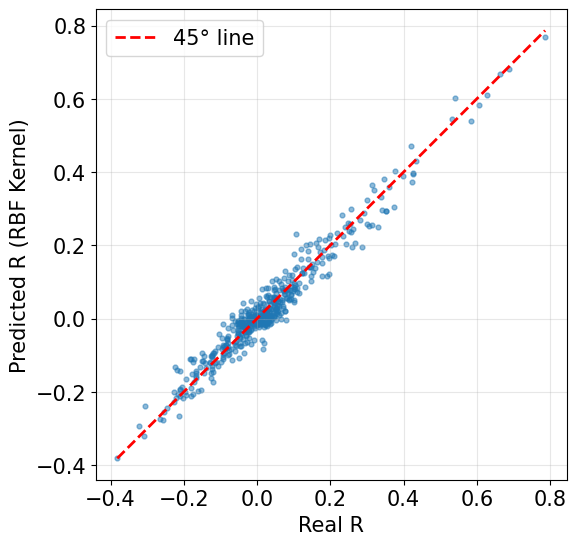

In [63]:
A = K + lam * np.eye(len(X))                        # Regularized Gram Matrix
alpha = np.linalg.solve(A, y_switching)             # Solve for dual coefficients α
R_pred_kernel_switching = K @ alpha                 # In-sample predictions (kernel)

plt.figure(figsize=(6, 6))
plt.scatter(y_switching, R_pred_kernel_switching, marker='o', s=12, alpha=0.5)

min_val = min(y_switching.min(), R_pred_kernel_switching.min())
max_val = max(y_switching.max(), R_pred_kernel_switching.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="45° line")

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Real R")
plt.ylabel("Predicted R (RBF Kernel)")
plt.xticks(np.arange(-0.4, 0.9, 0.2))
plt.yticks(np.arange(-0.4, 0.9, 0.2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("images/kernel_switching.pdf", dpi=300)
plt.show()

### 3.3. Performance Metrics

In [64]:
# Compute metrics for Linear Regression
r2_lin = r2_score(y_switching, R_pred_linear_switching)
rmse_lin = np.sqrt(mean_squared_error(y_switching, R_pred_linear_switching))
mae_lin = mean_absolute_error(y_switching, R_pred_linear_switching)
bias_lin = np.mean(R_pred_linear_switching - y_switching)
corr_lin = np.corrcoef(y_switching, R_pred_linear_switching)[0, 1]

# Compute metrics for Kernel Ridge Regression
r2_ker = r2_score(y_switching, R_pred_kernel_switching)
rmse_ker = np.sqrt(mean_squared_error(y_switching, R_pred_kernel_switching))
mae_ker = mean_absolute_error(y_switching, R_pred_kernel_switching)
bias_ker = np.mean(R_pred_kernel_switching - y_switching)
corr_ker = np.corrcoef(y_switching, R_pred_kernel_switching)[0, 1]

# Build summary table
summary_switching = pd.DataFrame({
    "Model": ["Linear", "Kernel"],
    "R2": [r2_lin, r2_ker],
    "RMSE": [rmse_lin, rmse_ker],
    "MAE": [mae_lin, mae_ker],
    "Bias": [bias_lin, bias_ker],
    "Corr(y, y_hat)": [corr_lin, corr_ker]
}).round(6)

print("Case 3 performance metrics:")
display(summary_switching)

Case 3 performance metrics:


,Model,R2,RMSE,MAE,Bias,"Corr(y, y_hat)"
0,Linear,0.545199,0.099767,0.070334,-0.000000,0.738376
1,Kernel,0.952246,0.032328,0.025232,-0.000016,0.975834


## 4. Comparison between Models

In [65]:
cases = {
    "Quadratic": {
        "R": R_quadratic,
        "y": y_quadratic,
        "y_pred_linear": R_pred_linear_quadratic,
        "y_pred_kernel": R_pred_kernel_quadratic,
    },
    "Interaction": {
        "R": R_interaction,
        "y": y_interaction,
        "y_pred_linear": R_pred_linear_interaction,
        "y_pred_kernel": R_pred_kernel_interaction,
    },
    "Switching": {
        "R": R_switching,
        "y": y_switching,
        "y_pred_linear": R_pred_linear_switching,
        "y_pred_kernel": R_pred_kernel_switching,
    },
}

### 4.1. Time Series of Returns

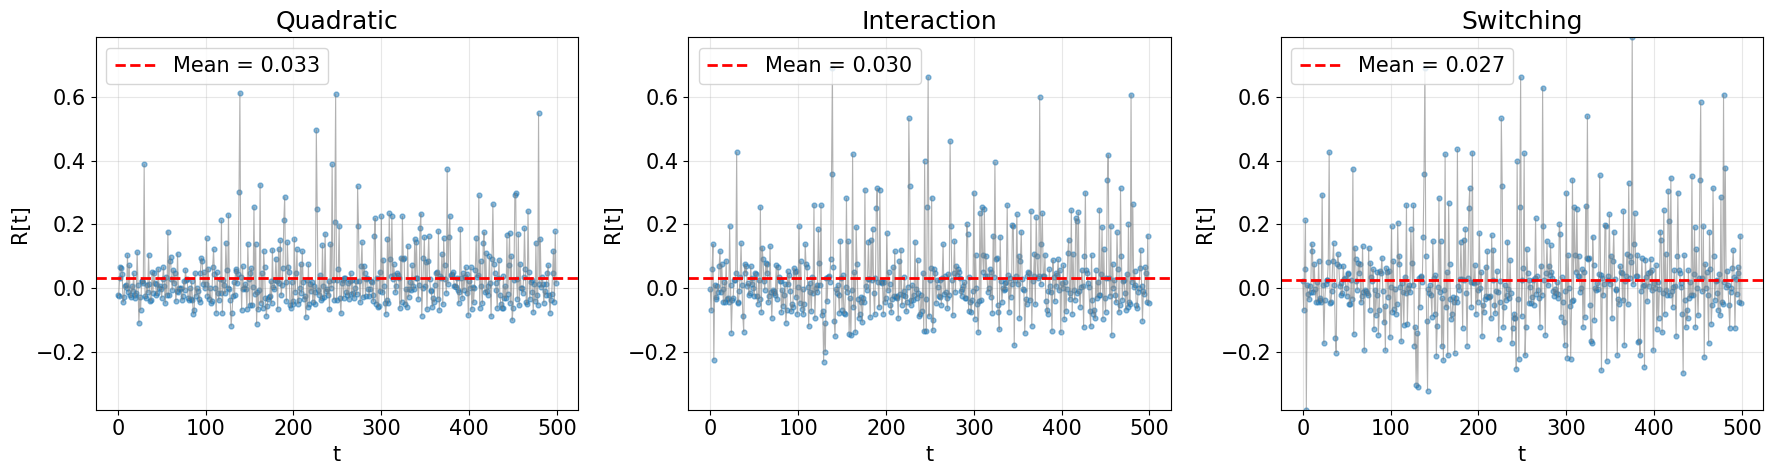

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)

all_R = np.concatenate([c["R"] for c in cases.values()])
y_min = all_R.min()
y_max = all_R.max()

for ax, (title, c) in zip(axes, cases.items()):
    R = c["R"]
    n = len(R)
    R_mean = R.mean()

    ax.plot(R, linewidth=0.8, color="gray", alpha=0.6)
    ax.scatter(range(n), R, marker='o', s=12, alpha=0.5)
    ax.axhline(R_mean, color="red", linestyle="--", linewidth=2, label=f"Mean = {R_mean:.3f}")
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("t")
    ax.set_ylabel("R[t]")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig("images/returns_all.pdf", dpi=300)
plt.show()

### 4.2. Linear Regression

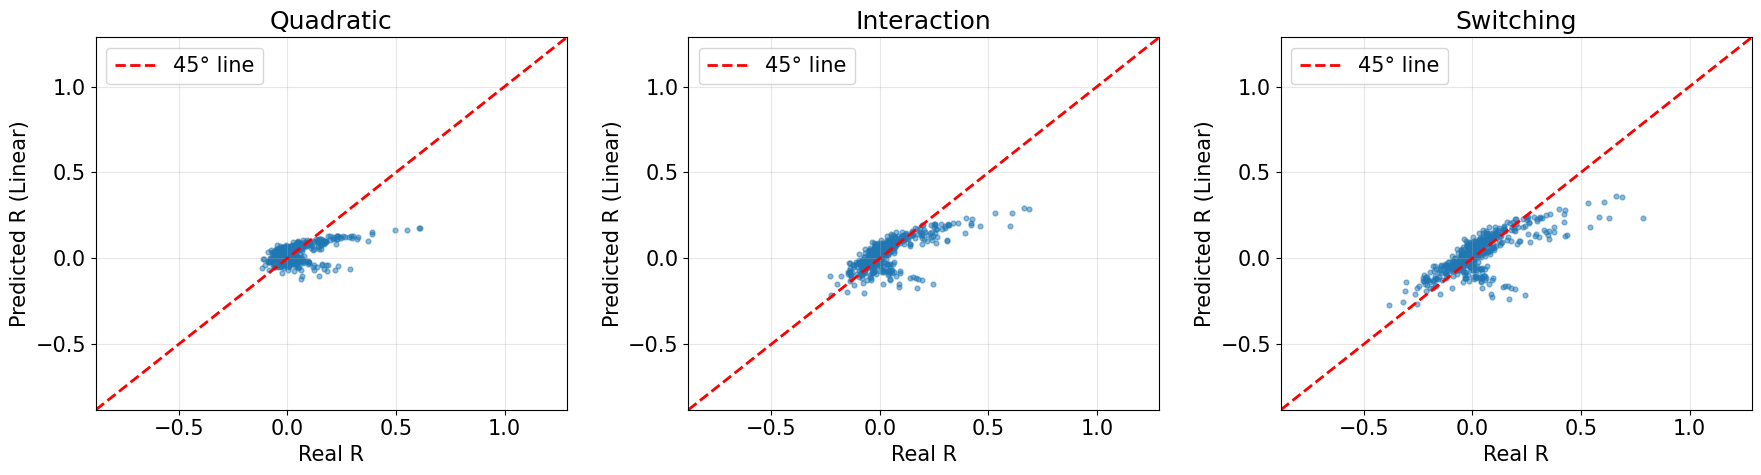

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)

all_real = np.concatenate([c["y"] for c in cases.values()])
all_pred_lin = np.concatenate([c["y_pred_linear"] for c in cases.values()])
global_min = min(all_real.min(), all_pred_lin.min())
global_max = max(all_real.max(), all_pred_lin.max())

margin = 0.5
x_min = global_min - margin
x_max = global_max + margin
y_min = global_min - margin
y_max = global_max + margin

for ax, (title, c) in zip(axes, cases.items()):
    y_true = c["y"]
    y_pred = c["y_pred_linear"]

    ax.scatter(y_true, y_pred, marker='o', s=12, alpha=0.5)
    ax.plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=2, label="45° line")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("Real R")
    ax.set_ylabel("Predicted R (Linear)")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig("images/linear_all.pdf", dpi=300)
plt.show()

### 4.3. Kernel Ridge Regression

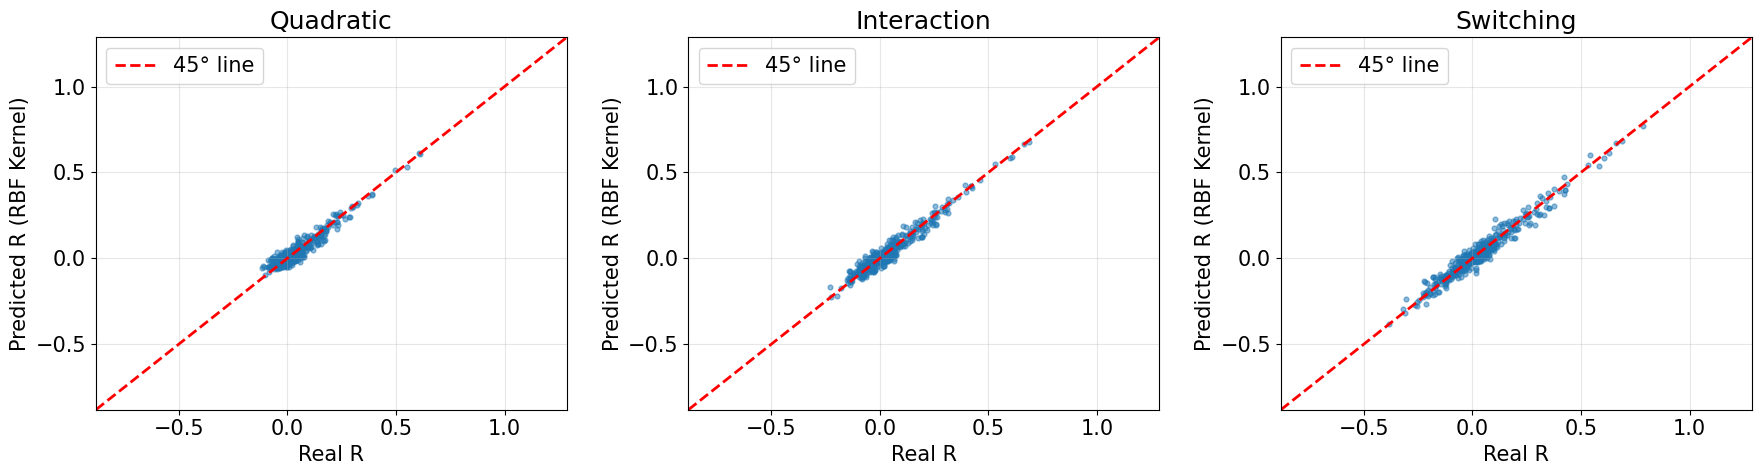

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=False)

all_real = np.concatenate([c["y"] for c in cases.values()])
all_pred_kernel = np.concatenate([c["y_pred_kernel"] for c in cases.values()])
global_min = min(all_real.min(), all_pred_kernel.min())
global_max = max(all_real.max(), all_pred_kernel.max())

margin = 0.5
x_min = global_min - margin
x_max = global_max + margin
y_min = global_min - margin
y_max = global_max + margin

for ax, (title, c) in zip(axes, cases.items()):
    y_true = c["y"]
    y_pred = c["y_pred_kernel"]

    ax.scatter(y_true, y_pred, marker='o', s=12, alpha=0.5)
    ax.plot([x_min, x_max], [y_min, y_max], color='red', linestyle='--', linewidth=2, label="45° line")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("Real R")
    ax.set_ylabel("Predicted R (RBF Kernel)")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

plt.tight_layout()
plt.savefig("images/kernel_all.pdf", dpi=300)
plt.show()

### 4.4. Performance Metrics

In [69]:
summary_quadratic["Case"] = "Quadratic"
summary_interaction["Case"] = "Interaction"
summary_switching["Case"] = "Switching"

cols = ["Case", "Model", "R2", "RMSE", "MAE", "Bias", "Corr(y, y_hat)"]

table_all = pd.concat([
    summary_quadratic[cols],
    summary_interaction[cols],
    summary_switching[cols]],
    ignore_index=True).round(6)

print("All cases performance metrics:")
display(table_all.set_index(["Case", "Model"]))

All cases performance metrics:


R2      RMSE       MAE      Bias  Corr(y, y_hat)
Case        Model                                                         
Quadratic   Linear  0.261338  0.082031  0.059006 -0.000000        0.511212
            Kernel  0.906657  0.029161  0.023096 -0.000018        0.952189
Interaction Linear  0.500116  0.085491  0.060026 -0.000000        0.707189
            Kernel  0.941819  0.029166  0.023116 -0.000017        0.970475
Switching   Linear  0.545199  0.099767  0.070334 -0.000000        0.738376
            Kernel  0.952246  0.032328  0.025232 -0.000016        0.975834

## 5. High-Noise Environment

$$
R_t = \theta_0 + \theta_1 F_t + \theta_2 V_t + \theta_3 F_t^2 + \theta_4 F_t V_t + \theta_5 H_t F_t + \varepsilon_t
$$

$$
\begin{aligned}
\text{a) Quadratic:}    &\quad \ F_t^2 \\
\text{b) Interaction:}  &\quad \ F_t V_t \\
\text{c) Switching:}    &\quad \ H_t F_t \\
\\
\text{Noise term:}          &\quad \varepsilon_t \sim \mathcal{N}(0,\sigma^2) \\
\text{Noise scale:} &\quad \cancel{0.03} \;\rightarrow\; 0.15 \\
\end{aligned}
$$

In [70]:
sigma_noise = 0.15                                          # Standard deviation of the noise
eps_noise = rng.normal(loc=0.0, scale=sigma_noise, size=n)  # Noise ε ~ N(0, σ²)

R_noise = (
      theta[0]
      + theta[1] * F
      + theta[2] * V
      + theta[3] * (F ** 2)
      + theta[4] * (F * V)
      + theta[5] * (H * F)
      + eps_noise
)

data_noise = pd.DataFrame({                         # Final dataset
    "F": F,                                         # Market factor
    "V": V,                                         # Volatility indicator
    "H": H,                                         # Regime indicator
    "R_noise": R_noise                              # Target return
})

### 5.1. Kernel Ridge Regression

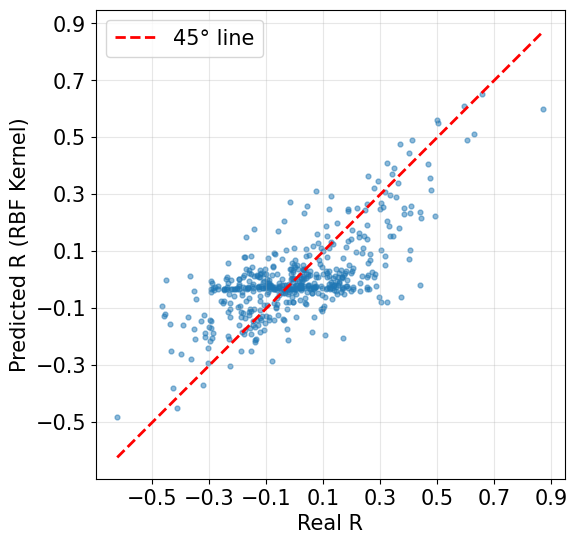

In [71]:
X = data_noise[["F", "V"]].to_numpy()
y_noise = data_noise["R_noise"].to_numpy()

A = K + lam * np.eye(len(X))                        # Regularized Gram Matrix
alpha = np.linalg.solve(A, y_noise)                 # Solve for dual coefficients α
R_pred_kernel_noise = K @ alpha                     # In-sample predictions (kernel)

plt.figure(figsize=(6, 6))
plt.scatter(y_noise, R_pred_kernel_noise, marker='o', s=12, alpha=0.5)

min_val = min(y_noise.min(), R_pred_kernel_noise.min())
max_val = max(y_noise.max(), R_pred_kernel_noise.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="45° line")

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Real R")
plt.ylabel("Predicted R (RBF Kernel)")
plt.xticks(np.arange(-0.5, 1.0, 0.2))
plt.yticks(np.arange(-0.5, 1.0, 0.2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("images/kernel_noise.pdf", dpi=300)
plt.show()

### 5.2. Performance Metrics

In [72]:
# Compute metrics for Kernel Ridge Regression
r2_noise = r2_score(y_noise, R_pred_kernel_noise)
rmse_noise = np.sqrt(mean_squared_error(y_noise, R_pred_kernel_noise))
mae_noise = mean_absolute_error(y_noise, R_pred_kernel_noise)
bias_noise = np.mean(R_pred_kernel_noise - y_noise)
corr_noise = np.corrcoef(y_noise, R_pred_kernel_noise)[0, 1]

# Build summary table
summary_noise = pd.DataFrame({
    "Model": ["Kernel"],
    "R2": [r2_noise],
    "RMSE": [rmse_noise],
    "MAE": [mae_noise],
    "Bias": [bias_noise],
    "Corr(y, y_hat)": [corr_noise]
})

summary_noise["Case"] = "Noise"

table_noise = pd.concat([
    summary_switching.loc[[1][:]],
    summary_noise[cols]],
    ignore_index=True).round(6)

print("Case 4 performance metrics (comparison):")
display(table_noise.set_index(["Case", "Model"]))

Case 4 performance metrics (comparison):


,,R2,RMSE,MAE,Bias,"Corr(y, y_hat)"
Case,Model,,,,,
Switching,Kernel,0.952246,0.032328,0.025232,-0.000016,0.975834
Noise,Kernel,0.500826,0.145495,0.115271,-0.000040,0.707750
